# Auto Insurance Fraud Detection

## Data preparation and Modeling 
Here we will prepare the data for the machine learning algorithms and asses the performance of multiple ML models

### Approach 
1. Check for missing values and non-informative features
2. Encoding of categorical values
3. Split data into training and hold out testing
4. Try out many models 
    * Hyperparameter tuning using grid-search
    * Evaluation on hold-out testing data
    * Performance analysis based on model evaluation metrics
5. Select the best model 

The final model can then be deployed to flag a given insurance claim as fraudulent or legitimate


### Importing all the necessary packages

In [1]:
import pandas as pd
import numpy as np
import itertools
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis



import sklearn.metrics
from pylab import rcParams
plt.style.use('seaborn')
%matplotlib inline

# Turning-off the warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
#load & view the data
df = pd.read_csv('insurance_claims.csv')
df.head(10)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
5,256,39,104594,2006-10-12,OH,250/500,1000,1351.10,0,478456,...,NO,64100,6410,6410,51280,Saab,95,2003,Y,NaN
6,137,34,413978,2000-06-04,IN,250/500,1000,1333.35,0,441716,...,?,78650,21450,7150,50050,Nissan,Pathfinder,2012,N,NaN
7,165,37,429027,1990-02-03,IL,100/300,1000,1137.03,0,603195,...,YES,51590,9380,9380,32830,Audi,A5,2015,N,NaN
8,27,33,485665,1997-02-05,IL,100/300,500,1442.99,0,601734,...,YES,27700,2770,2770,22160,Toyota,Camry,2012,N,NaN
9,212,42,636550,2011-07-25,IL,100/300,500,1315.68,0,600983,...,?,42300,4700,4700,32900,Saab,92x,1996,N,NaN


In [3]:
# unique entries. Useful to know the catagorical features
df.nunique()

months_as_customer              391
age                              46
policy_number                  1000
policy_bind_date                951
policy_state                      3
policy_csl                        3
policy_deductable                 3
policy_annual_premium           991
umbrella_limit                   11
insured_zip                     995
insured_sex                       2
insured_education_level           7
insured_occupation               14
insured_hobbies                  20
insured_relationship              6
capital-gains                   338
capital-loss                    354
incident_date                    60
incident_type                     4
collision_type                    4
incident_severity                 4
authorities_contacted             5
incident_state                    7
incident_city                     7
incident_location              1000
incident_hour_of_the_day         24
number_of_vehicles_involved       4
property_damage             

### Data preprocessing and cleaning

In [4]:
# Total number of missing values
df.isna().sum().sum()


1000

In [5]:
# column with missing values 
df.columns[df.isna().any()] 


Index(['_c39'], dtype='object')

all of the missing values are in the _c39 column. We will drop it later.

In [6]:
# columns with ? entries
df.columns[(df == '?').any()]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Index(['collision_type', 'property_damage', 'police_report_available'], dtype='object')

In [7]:
df[df.columns[(df == '?').any()]].nunique()

collision_type             4
property_damage            3
police_report_available    3
dtype: int64

property_damage and police_report_available are boolean (YES/NO) types. Hence, we will regard the missing values as NO. The collision_type can be side, rear, and front. We will just regard the ? as a separate collision type. 

In [8]:
df['property_damage'].replace(to_replace='?', value='NO', inplace=True)
df['police_report_available'].replace(to_replace='?', value='NO', inplace=True)

In [9]:
# check if there are duplicated entries
df.duplicated(subset=None, keep='first').sum()

0

In [10]:
# dropping uninformative features
colsToDelete = ["policy_number", "policy_bind_date", "insured_zip", "incident_location", "incident_date", "_c39"]
df = df.drop(columns = colsToDelete, axis=1)
df.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,...,0,NO,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


### Identify and remove highly correlated features 


In [11]:
threshold = 0.97
# calculate correlations
corr_matrix = df.corr().abs()
# get the upper part of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# columns with correlation above threshold
redundent = [column for column in upper.columns if any(upper[column] >= threshold)]
print(f'Columns to drop with correlation > {threshold}: {redundent}')
df.drop(columns=redundent, inplace=True)

Columns to drop with correlation > 0.97: ['vehicle_claim']


### Now let's find the catagorical features 
#### They should be one-hot-encode  Now let's find the catagorical features and one-hot-encode them

In [12]:
num_features = df._get_numeric_data().columns
cat_features = list(set(df.columns) - set(num_features))
cat_features.remove('fraud_reported')

In [13]:
cat_features

['authorities_contacted',
 'insured_education_level',
 'property_damage',
 'insured_hobbies',
 'policy_csl',
 'police_report_available',
 'insured_relationship',
 'incident_type',
 'auto_model',
 'auto_make',
 'incident_severity',
 'collision_type',
 'incident_city',
 'incident_state',
 'policy_state',
 'insured_sex',
 'insured_occupation']

In [14]:
df[num_features].head()

,months_as_customer,age,policy_deductable,policy_annual_premium,umbrella_limit,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,auto_year
0,328,48,1000,1406.91,0,53300,0,5,1,1,2,71610,6510,13020,2004
1,228,42,2000,1197.22,5000000,0,0,8,1,0,0,5070,780,780,2007
2,134,29,2000,1413.14,5000000,35100,0,7,3,2,3,34650,7700,3850,2007
3,256,41,2000,1415.74,6000000,48900,-62400,5,1,1,2,63400,6340,6340,2014
4,228,44,1000,1583.91,6000000,66000,-46000,20,1,0,1,6500,1300,650,2009


In [15]:
df[cat_features].head()

,authorities_contacted,insured_education_level,property_damage,insured_hobbies,policy_csl,police_report_available,insured_relationship,incident_type,auto_model,auto_make,incident_severity,collision_type,incident_city,incident_state,policy_state,insured_sex,insured_occupation
0,Police,MD,YES,sleeping,250/500,YES,husband,Single Vehicle Collision,92x,Saab,Major Damage,Side Collision,Columbus,SC,OH,MALE,craft-repair
1,Police,MD,NO,reading,250/500,NO,other-relative,Vehicle Theft,E400,Mercedes,Minor Damage,?,Riverwood,VA,IN,MALE,machine-op-inspct
2,Police,PhD,NO,board-games,100/300,NO,own-child,Multi-vehicle Collision,RAM,Dodge,Minor Damage,Rear Collision,Columbus,NY,OH,FEMALE,sales
3,Police,PhD,NO,board-games,250/500,NO,unmarried,Single Vehicle Collision,Tahoe,Chevrolet,Major Damage,Front Collision,Arlington,OH,IL,FEMALE,armed-forces
4,None,Associate,NO,board-games,500/1000,NO,unmarried,Vehicle Theft,RSX,Accura,Minor Damage,?,Arlington,NY,IL,MALE,sales


### Separate the target column from the features

In [16]:
# separate the target column from the features
y = df["fraud_reported"].map({"N":0, "Y":1})
X = df.drop("fraud_reported", axis=1)

### Set up a preprocessing pipeline to one-hot-encode catagorical features and let the numerical features passthrough as they are 

In [17]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

### Define the ML models 

In [18]:
# Logistic Regression
lr_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42))])

# Decision Tree
dt_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", DecisionTreeClassifier(class_weight="balanced"))])
# LDA
lda_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", LinearDiscriminantAnalysis())])

# Random Forest
rf_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", RandomForestClassifier(class_weight="balanced", n_estimators=100, n_jobs=-1))])



##### Lets define a function to automate  split the data into training and test sets and compute multiple evaluation matrices and plot ROC and PVR curves. 

Since we have an imbalanced dataset, we can't use metrics such as Accuracy. Instead, we will be mainly using the Receiver Operating Characteristic Area Under the Curve (ROC AUC). Precision, Recall, and fl-score are also other alternatives. 

    * It should be noted that the choice of the metric depends on the business requirement. Hence, models can be optimized accordingly. 

The 5xcv cross-validation gives a better sense of the average performance of the model. 

First lets write a function to plot ROC and PVR curves 

In [19]:
# A function to plot the ROC and PVR curves 
def plot_eval(testY, predY, auc):  
    fpr, tpr, thresh = sklearn.metrics.roc_curve(testY, predY[:,1])
    
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.legend()
    plt.show()
    
    precision_rt, recall_rt, threshold_rt = sklearn.metrics.precision_recall_curve(testY, predY[:,1])
    plt.plot(recall_rt, precision_rt, linewidth=5, label='Precision-Recall curve')
    plt.title('Recall vs Precision')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()

In [20]:
def model_evaluate(model, X, y, grid_params, plot_eval_curves = False):
    """Prepares a training and test set and evaluates the ML model
       on multiple metrices 
    
    Arguments:
    ---------
    model:        a defined ML model

    X:            the feature matix

    y:            the labels 

    grid_params:  hyperparameters to perform grid search on (dict)

    plot_eval_curves: If False, outputs metrices 
                      If True, plots ROC and precision vs. recall curves 
    """
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=555)
    
    gs = GridSearchCV(model, grid_params, 
                  n_jobs=-1, cv=5, scoring="roc_auc")

    gs.fit(X_train, y_train)

    model.set_params(**gs.best_params_)
    
    model.fit(X_train, y_train)
    
    # Predict probabilities and labels
    probs = model.predict_proba(X_test)
    preds = model.predict(X_test)
    
    # Calculate ROC AUC
    auc = sklearn.metrics.roc_auc_score(y_test, probs[:, 1])
    # get the confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_test, preds)    
    # Plot ROC curve
    if plot_eval_curves:
        plot_eval(y_test, probs, auc)
    else: 
        print('Best Parameters:', gs.best_params_)
        print('Best Score:', gs.best_score_)
        print(f'ROC AUC: {round(auc, 4)}')
        print(f'Confusion Matrix:\n {cnf_matrix}')
        # compute the other evaluation metrices 
        for metric in [sklearn.metrics.precision_score, sklearn.metrics.recall_score, sklearn.metrics.f1_score]:
            print(f'{metric.__name__}: {round(metric(y_test, preds), 4)}')

        # Average performance using 5 x cross-validation    
        score = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
        print('Cross-validation AUC score: ', score.mean()) 
    return model, cnf_matrix




In [21]:
# Grid-search hyper Parameters to consider
model_grid_params = {'lr_model': {"model__C": [1, 1.3, 1.5]}, 'dt_model': {"model__max_depth": [3, 5, 7], "model__min_samples_split": [2, 5]}, 
              'rf_model': {"model__max_depth": [20, 10, 15],"model__min_samples_split": [5, 10]}, 'lda_model': {}, }

In [22]:
models = [lr_model, dt_model, rf_model, lda_model]
model_keys = [('lr_model', 'Logistic Regression'),
              ('dt_model', 'Decision Tree'),
              ('rf_model', 'Random Forest'),
              ('lda_model', 'Linear Discriminant Analysis')]

In [23]:
final_model, cnf_matrix = {}, {}
for idx, model in enumerate(models):
    print(45*'_', '\n{}'.format(model_keys[idx][1]))
    model, cnf = model_evaluate(model, X, y, model_grid_params[model_keys[idx][0]])
    final_model[model_keys[idx][0]] = model
    cnf_matrix[model_keys[idx][0]] = cnf 

_____________________________________________ 
Logistic Regression
Best Parameters: {'model__C': 1}
Best Score: 0.5939362682771774
ROC AUC: 0.5655
Confusion Matrix:
 [[76 75]
 [24 25]]
precision_score: 0.25
recall_score: 0.5102
f1_score: 0.3356
Cross-validation AUC score:  0.5943034247871335
_____________________________________________ 
Decision Tree
Best Parameters: {'model__max_depth': 3, 'model__min_samples_split': 2}
Best Score: 0.8338993960584871
ROC AUC: 0.8241
Confusion Matrix:
 [[126  25]
 [  9  40]]
precision_score: 0.6154
recall_score: 0.8163
f1_score: 0.7018
Cross-validation AUC score:  0.8489145235842681
_____________________________________________ 
Random Forest
Best Parameters: {'model__max_depth': 20, 'model__min_samples_split': 10}
Best Score: 0.8624010913329097
ROC AUC: 0.8109
Confusion Matrix:
 [[129  22]
 [ 19  30]]
precision_score: 0.5769
recall_score: 0.6122
f1_score: 0.5941
Cross-validation AUC score:  0.8393165310627563
_________________________________________

#### Overall, the LDA model provided the better result (87% AUC and 71% fl_score) . 

##### The Decision Tree model is also as good as the LDA.  Although, the RF classifier has a comparable  AUC score the f1_score is very low. Hence, we will take the LDA or the Decision Tree model as our final model

### Lets have a closer look at the predictions of the LDA model

In [24]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

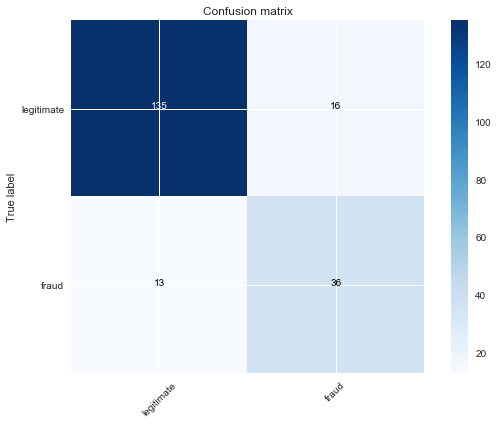

In [25]:
# Plot the confusion matrix of the LDA model
plot_confusion_matrix(cnf_matrix['lda_model'], target_names=['legitimate', 'fraud'], normalize=False)

 - 135 legitimate transactions were correctly classified
 - 16 legitimate transactions classified as fraudulant, i.e., false positives (type 1 error)
 - 36 fraudulant transactions transactions were correctly identified 
 - 13 fraudulant transactions were classified as legitimate (type 2 error)

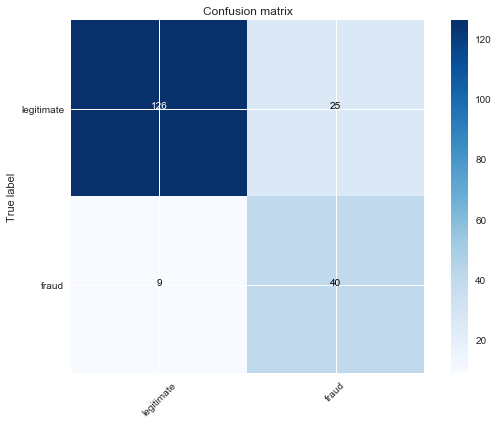

In [26]:
# Plot the confusion matrix of the DT model
plot_confusion_matrix(cnf_matrix['dt_model'], target_names=['legitimate', 'fraud'], normalize=False)

### The ROC curve 

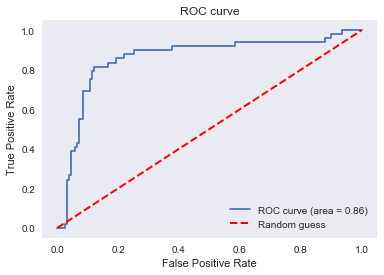

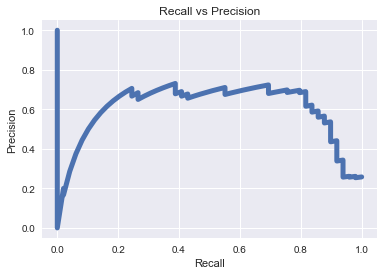

In [27]:
# ROC curve LDA 
model, cnf = model_evaluate(lda_model, X, y, model_grid_params['lda_model'], plot_eval_curves=True)

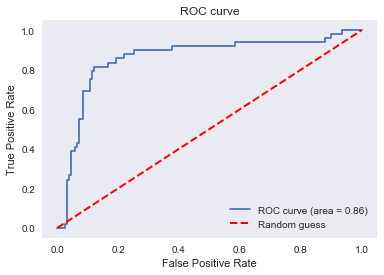

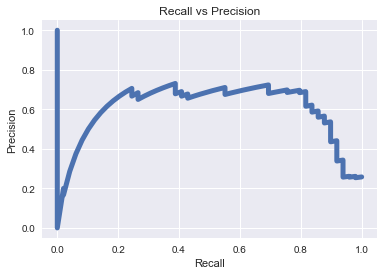

In [28]:
# ROC and Precision vs. Recall curves of the LDA model 
model, cnf = model_evaluate(lda_model, X, y, model_grid_params['lda_model'], plot_eval_curves=True)

#### The precision vs. recall curve shows the trade off between missing a fraudulent transaction and falsely flagging a legitimate transaction as a fraudulent. Depending on the business requirment, possibly discussing with the business stakeholders, we have to choose an optimal point.

#### Since, Understanding why the ML algorithm made the decision is very important, next I will work on model explainability.  